In [26]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

import math
import sys
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,  Activation, LSTM, Embedding, Dropout, Concatenate, Input, ReLU
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences 
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

### Data Exploration

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.dropna(inplace=True)

In [6]:
train['Times'].describe()

count    92667.000000
mean         1.844972
std         11.190302
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       1688.000000
Name: Times, dtype: float64

In [7]:
y = train.Times
train.drop(columns='Times', inplace=True)
test.drop(columns='Id', inplace=True)

Let's generate some features:

- password length
- digits count
- letters count
- special symbols count
- unique symbols count
- uppercase symbols count
- lowercase symbols count

In [13]:
def count_digits(password):
    return sum((c.isdigit() for c in password))

def count_letters(password):
    return sum((c.isalpha() for c in password))

def count_special(password):
    return sum((1 for c in password if not (c.isalpha() or c.isdigit())))

def count_unique(password):
    ps = set(password)
    return len(ps)

def count_uppercase(password):
    return sum((c.isupper() for c in password))

def count_lowercase(password):
    return sum((c.islower() for c in password))

In [14]:
def preprocess_data(df):
    df['len'] = df['Password'].str.len()
    df['Password'] = df['Password'].apply(lambda x: str(x))
    df['n_lowercase'] = df['Password'].apply(lambda x: count_lowercase(x))
    df['n_digits'] = df['Password'].apply(lambda x: count_digits(x))
    df['n_letters'] = df['Password'].apply(lambda x: count_letters(x))
    df['n_special'] = df['Password'].apply(lambda x: count_special(x))
    df['n_unique'] = df['Password'].apply(lambda x: count_unique(x))
    df['n_uppercase'] = df['Password'].apply(lambda x: count_uppercase(x))
    df['n_lowercase'] = df['Password'].apply(lambda x: count_lowercase(x))
    return df

In [15]:
preprocessed_train = preprocess_data(train)
preprocessed_test = preprocess_data(test)

In [16]:
preprocessed_train.head()

,Password,len,n_lowercase,n_digits,n_letters,n_special,n_unique,n_uppercase
0,631XniVx2lS5I,13,4,5,8,0,13,4
1,LEGIT747,8,0,3,5,0,7,5
2,742364es,8,2,6,2,0,7,0
3,3846696477,10,0,10,0,0,6,0
4,laurahop,8,8,0,8,0,7,0


**Train-test split**

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    preprocessed_train.drop(['Password'], axis=1),
    y,
    test_size=0.1,
    random_state=87
)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape, end='\n\n')

print('X_val:', X_val.shape)
print('y_val:', y_val.shape, end='\n\n')

X_train: (2665848, 7)
y_train: (2665848,)

X_val: (296206, 7)
y_val: (296206,)



**Simple linear regression**

In [32]:
%%time

lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_val)
preds[preds < 0] = 0
mean_squared_log_error(y_val, preds, squared=False)

CPU times: user 679 ms, sys: 131 ms, total: 810 ms
Wall time: 752 ms


0.5023182001854288

**RandomForest Regressor**

Default

In [40]:
X_train.shape

(2665848, 7)

In [42]:
%%time

rf = RandomForestRegressor(random_state=2022, max_depth=10)
rf.fit(X_train[:100000], y_train[:100000])
preds = rf.predict(X_val)
preds[preds < 0] = 0
mean_squared_log_error(y_val, preds, squared=False)

CPU times: user 10.7 s, sys: 48.8 ms, total: 10.7 s
Wall time: 12.1 s


0.5018242346433415

With simple hyperparameters optimization

In [45]:
rf = RandomForestRegressor(random_state=2022)
distributions = dict(
    n_estimators=[100, 150, 200],
    max_depth=[10, 8, 6]
)

cv = RandomizedSearchCV(rf, distributions, random_state=2022)
search = cv.fit(X_train[:100000], y_train[:100000])
search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


{'n_estimators': 200, 'max_depth': 6}

In [46]:
preds = search.predict(X_val)
preds[preds < 0] = 0
mean_squared_log_error(y_val, preds, squared=False)

0.5000166202467875

**Custom Simple LSTM**

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.dropna(inplace=True)

In [10]:
df = train.copy()
df.head()

,Password,Times
0,631XniVx2lS5I,2
1,LEGIT747,1
2,742364es,1
3,3846696477,1
4,laurahop,2


In [11]:
df['Password'] = df['Password'] .fillna('')

In [12]:
tokenizer = Tokenizer(100, filters='', lower=False)
tokenizer.fit_on_texts(df['Password'])
tokens = tokenizer.texts_to_sequences(df['Password'])

In [13]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
df['len'] = df['Password'].str.len()
df_tokenized = pad_sequences(tokens, df['len'].max(), padding='post')
print(df_tokenized.shape)

(277636, 39)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_tokenized, df['Times'], test_size=0.1, random_state=87)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape, end='\n\n')

print('X_val:', X_val.shape)
print('y_val:', y_val.shape, end='\n\n')

X_train: (249872, 39)
y_train: (249872,)

X_val: (27764, 39)
y_val: (27764,)



**Model**

In [16]:
def rmsle(y_true, y_pred):
    """Loss function"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.math.sqrt(
        tf.reduce_mean(
            tf.math.squared_difference(tf.math.log1p(y_pred), tf.math.log1p(y_true))
        )
    )

In [19]:
EMBEDDING_VECTOR_LENGHT = 16
HIDDEN_DIM = 16

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

model = Sequential()
model.add(Embedding(100, EMBEDDING_VECTOR_LENGHT, input_length=df['len'].max(), mask_zero=True,))

model.add(LSTM(HIDDEN_DIM))
model.add(Dense(1))
model.add(ReLU())

opt = Adam()
model.compile(loss=rmsle, optimizer=opt)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 16)            1600      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
 re_lu_1 (ReLU)              (None, 1)                 0         
                                                                 
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=512,
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/20
489/489 [==============================] - 52s 98ms/step - loss: 0.7419 - val_loss: 0.6121
Epoch 2/20
489/489 [==============================] - 48s 98ms/step - loss: 0.5328 - val_loss: 0.4763
Epoch 3/20
489/489 [==============================] - 47s 95ms/step - loss: 0.4430 - val_loss: 0.4244
Epoch 4/20
489/489 [==============================] - 48s 97ms/step - loss: 0.4124 - val_loss: 0.4094
Epoch 5/20
489/489 [==============================] - 47s 95ms/step - loss: 0.4046 - val_loss: 0.4061
Epoch 6/20
489/489 [==============================] - 46s 95ms/step - loss: 0.4035 - val_loss: 0.4057
Epoch 7/20
489/489 [==============================] - 47s 96ms/step - loss: 0.4030 - val_loss: 0.4056
Epoch 8/20
489/489 [==============================] - 46s 95ms/step - loss: 0.4028 - val_loss: 0.4056
Epoch 9/20
489/489 [==============================] - 46s 94ms/step - loss: 0.4029 - val_loss: 0.4056


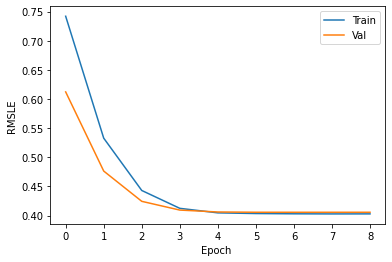

In [22]:
plt.plot(hist.history['loss'], label = 'Train');
plt.plot(hist.history['val_loss'], label ='Val');
plt.legend();
plt.xlabel('Epoch ');
plt.ylabel('RMSLE');

In [23]:
model.save('lstm_model') 

**Prediction**

In [27]:
preds = model.predict(X_val)
preds[preds < 0] = 0
mean_squared_log_error(y_val, preds, squared=False)

868/868 [==============================] - 7s 8ms/step


0.4091827400076979